In [1]:
import numpy as np 
import xarray as xr
import pandas as pd 
import os.path
import matplotlib.pyplot as plt 

apply combined linear and exponential predictors

In [22]:
# start from 2015 and lead=1
dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'
lead = [1, 5, 10, 15, 20, 25]   # select the prediction lead
stp = [4, 5, 5, 5, 5, 5]
BCC = np.zeros(len(lead))
RMSE = np.zeros(len(lead))
err  = np.zeros(len(lead))
mem = [[lead[0],lead[0]+stp[0]],[lead[1],lead[1]+stp[1]],[lead[2],lead[2]+stp[2]],[lead[3],lead[3]+stp[3]],[lead[4],lead[4]+stp[4]],[lead[5],lead[5]+stp[5]]]
memlen = len(mem[0])  # include two time steps
c = 0.05
mu = 0.5
npfm = 5 # use 5-day averaged performance

for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
    ds = []
    for imem, memstp in zip(np.arange(memlen),mem[ilead]):
        # combine 2015-2019 prediction for the lead
        dsp = []
        dst = []
        dspstd = []

        for yn in np.arange(2015,2020):
            fnp=dirn + 'predicted_disav_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(memstp) + '_dailyinput_mem1d' + str(yn) + '.csv'
            fnt=dirn + 'truth_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(memstp) + '_dailyinput_mem1d' + str(yn) + '.csv'
            fnpstd=dirn + 'predicted_disstd_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(memstp) + '_dailyinput_mem1d' + str(yn) + '.csv'

            df = pd.read_csv(fnp,index_col=None, header=None, names=['RMMp1','RMMp2'])
            dsp.append(df)
            del df 
            df = pd.read_csv(fnt,index_col=None, header=None, names=['RMMt1','RMMt2'])
            dst.append(df)
            del df 
            df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
            dspstd.append(df)
            del df 

        dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
        dst0 = pd.concat(dst, axis=0, ignore_index=True)
        dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

        ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

        ds.append(ds0)
        del ds0
        
    ds[0]['AdRMMp1'] = 0.0
    ds[0]['w11'] = 0.0
    ds[0]['w15'] = 0.0

    for i in np.arange(npfm+stp[ilead]+leadmjo,len(ds[1]['RMMp1'])):
        # calculate combined weights 
        # lead = 6
        a = np.exp(- c * (1.0 - mu) * (np.absolute(ds[1]['RMMp1'][i-leadmjo-stp[ilead]-1] - ds[1]['RMMt1'][i-leadmjo-stp[ilead]-1])
                                            + np.absolute(ds[1]['RMMp1'][i-leadmjo-stp[ilead]-2] - ds[1]['RMMt1'][i-leadmjo-stp[ilead]-2])
                                            + np.absolute(ds[1]['RMMp1'][i-leadmjo-stp[ilead]-3] - ds[1]['RMMt1'][i-leadmjo-stp[ilead]-3])
                                            + np.absolute(ds[1]['RMMp1'][i-leadmjo-stp[ilead]-4] - ds[1]['RMMt1'][i-leadmjo-stp[ilead]-4])
                                            + np.absolute(ds[1]['RMMp1'][i-leadmjo-stp[ilead]-5] - ds[1]['RMMt1'][i-leadmjo-stp[ilead]-5])))
        
        # lead = 1
        b = np.exp(- c * (1.0 - mu) * (np.absolute(ds[0]['RMMp1'][i-leadmjo-1] - ds[0]['RMMt1'][i-leadmjo-1])
                                            + np.absolute(ds[0]['RMMp1'][i-leadmjo-2] - ds[0]['RMMt1'][i-leadmjo-2])
                                            + np.absolute(ds[0]['RMMp1'][i-leadmjo-3] - ds[0]['RMMt1'][i-leadmjo-3])
                                            + np.absolute(ds[0]['RMMp1'][i-leadmjo-4] - ds[0]['RMMt1'][i-leadmjo-4])
                                            + np.absolute(ds[0]['RMMp1'][i-leadmjo-5] - ds[0]['RMMt1'][i-leadmjo-5])))
        ds[0]['w15'][i] = a / (a + b)
        ds[0]['w11'][i] = b / (a + b)
        del a 
        del b 
        # ds[0]['w15'][i] = np.exp(- c * (1.0 - mu) * (np.absolute(ds[1]['RMMp1'][0:-10:] - ds[1]['RMMt1'][0:-10:])
        #                                                 + np.absolute(ds[1]['RMMp1'][1:-9:] - ds[1]['RMMt1'][1:-9:])
        #                                                 + np.absolute(ds[1]['RMMp1'][2:-8:] - ds[1]['RMMt1'][2:-8:])
        #                                                 + np.absolute(ds[1]['RMMp1'][3:-7:] - ds[1]['RMMt1'][3:-7:])))

        # ds[0]['w11'][10::] = np.exp(- c * (1.0 - mu) * (np.absolute(ds[0]['RMMp1'][4:-6:] - ds[0]['RMMt1'][4:-6:])
        #                                                 + np.absolute(ds[0]['RMMp1'][5:-5:] - ds[0]['RMMt1'][5:-5:])
        #                                                 + np.absolute(ds[0]['RMMp1'][6:-4:] - ds[0]['RMMt1'][6:-4:])
        #                                                 + np.absolute(ds[0]['RMMp1'][7:-3:] - ds[0]['RMMt1'][7:-3:])))

    ds[0]['w21'] = 0.0
    ds[0]['w25'] = 0.0
    ds[0]['AdRMMp2'] = 0.0 
    for i in np.arange(npfm+stp[ilead]+leadmjo,len(ds[1]['RMMp2'])):
        a = np.exp(- c * (1.0 - mu) * (np.absolute(ds[1]['RMMp2'][i-leadmjo-stp[ilead]-1] - ds[1]['RMMt2'][i-leadmjo-stp[ilead]-1])
                                            + np.absolute(ds[1]['RMMp2'][i-leadmjo-stp[ilead]-2] - ds[1]['RMMt2'][i-leadmjo-stp[ilead]-2])
                                            + np.absolute(ds[1]['RMMp2'][i-leadmjo-stp[ilead]-3] - ds[1]['RMMt2'][i-leadmjo-stp[ilead]-3])
                                            + np.absolute(ds[1]['RMMp2'][i-leadmjo-stp[ilead]-4] - ds[1]['RMMt2'][i-leadmjo-stp[ilead]-4])
                                            + np.absolute(ds[1]['RMMp2'][i-leadmjo-stp[ilead]-5] - ds[1]['RMMt2'][i-leadmjo-stp[ilead]-5])))
        
        # lead = 1
        b = np.exp(- c * (1.0 - mu) * (np.absolute(ds[0]['RMMp2'][i-leadmjo-1] - ds[0]['RMMt2'][i-leadmjo-1])
                                            + np.absolute(ds[0]['RMMp2'][i-leadmjo-2] - ds[0]['RMMt2'][i-leadmjo-2])
                                            + np.absolute(ds[0]['RMMp2'][i-leadmjo-3] - ds[0]['RMMt2'][i-leadmjo-3])
                                            + np.absolute(ds[0]['RMMp2'][i-leadmjo-4] - ds[0]['RMMt2'][i-leadmjo-4])
                                            + np.absolute(ds[0]['RMMp2'][i-leadmjo-5] - ds[0]['RMMt2'][i-leadmjo-5])))
        ds[0]['w25'][i] = a / (a + b)
        ds[0]['w21'][i] = b / (a + b)
        del a 
        del b 

    w11 = ds[0]['w11'] 
    w15 = ds[0]['w15'] 
    w21 = ds[0]['w21']
    w25 = ds[0]['w25']

    ds[0]['Adstd1'] = 0.0 
    ds[0]['Adstd2'] = 0.0 

    for i in np.arange(npfm+stp[ilead]+leadmjo,len(ds[0]['w11'])):
        ds[0]['AdRMMp1'][i] = w11[i] * ds[0]['RMMp1'][i-leadmjo] + w15[i] * ds[1]['RMMp1'][i-leadmjo-stp[ilead]]
        ds[0]['AdRMMp2'][i] = w21[i] * ds[0]['RMMp2'][i-leadmjo] + w25[i] * ds[1]['RMMp2'][i-leadmjo-stp[ilead]]
        ds[0]['Adstd1'][i] = w11[i] * ds[0]['std1'][i-leadmjo] + w15[i] * ds[1]['std1'][i-leadmjo-stp[ilead]]
        ds[0]['Adstd2'][i] = w21[i] * ds[0]['std2'][i-leadmjo] + w25[i] * ds[1]['std2'][i-leadmjo-stp[ilead]]

    iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
    a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
    b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))
    iniRMM = xr.concat((a,b), dim='time')
    del a 
    del b 
    RMM1 = iniRMM['RMM'][:,0]
    RMM2 = iniRMM['RMM'][:,1]
    IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
    ds[0]['IniAmp'] = IniAmp.values 

    std1 = ds[0]['Adstd1']
    std2 = ds[0]['Adstd2']
    std = np.sqrt(std1*std1+std2*std2) / 2.0
    ds[0]['Adstd'] = std.values

    # finish combination
    # evaluation starts 
    ds = ds[0]
    ds = ds.loc[ds['IniAmp']>=1]

    r1p = np.asarray(ds['AdRMMp1'])
    r2p = np.asarray(ds['AdRMMp2'])
    r1t = np.asarray(ds['RMMt1'])
    r2t = np.asarray(ds['RMMt2'])
    std = np.asarray(ds['Adstd'])

    A = np.sum(r1p * r1t + r2p * r2t)
    B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
    C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
    BCC[ilead] = A / B / C 

    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    RMSE[ilead] = np.sqrt(np.mean(d))
    err[ilead] = np.mean(std)
    del ds 

print(BCC)
print(RMSE)
print(err)


[ 0.93419917  0.61978387  0.18442285 -0.09588416 -0.13187952 -0.13033345]
[0.66579195 1.32731937 1.65171342 1.73471773 1.67622081 1.60981235]
[0.13383323 0.12714458 0.12784873 0.13709614 0.1427708  0.1396266 ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'RMSE')

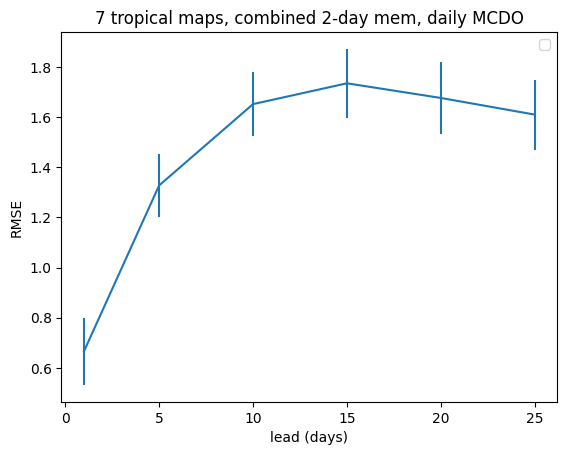

In [23]:
import matplotlib.pyplot as plt 

plt.errorbar(lead, RMSE, yerr=err)

plt.legend()
plt.title('7 tropical maps, combined 2-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'BCC')

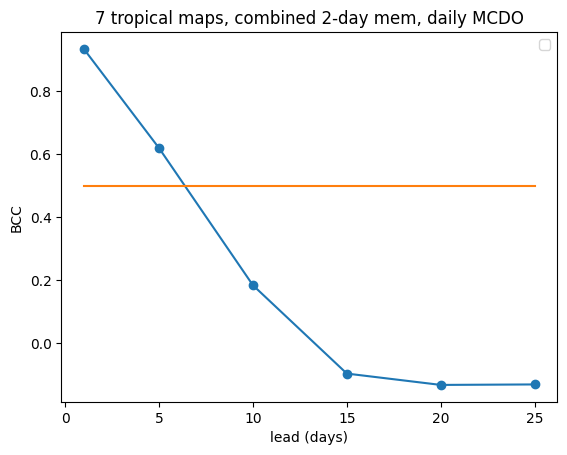

In [24]:
import matplotlib.pyplot as plt 
plt.plot(lead, BCC, 'o-')
plt.plot(lead, 0.5 * np.ones(len(lead)))
plt.legend()
plt.title('7 tropical maps, combined 2-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

In [2]:
dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'
RMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_6hr.nc')
RMM = RMM['RMM']
RMM

<xarray.DataArray 'RMM' (time: 63428, mode: 2)>
[126856 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2022-05-31T18:00:00
  * mode     (mode) int64 0 1

In [2]:
dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

iniRMM = xr.concat((a,b), dim='time')
RMSE = np.zeros((8,5))
BCC = np.zeros((8,5))
err = np.zeros((8,5))
del a 

for i,lead in zip(np.arange(0,8),[1,3,5,10,15,20,25,30]):
    for yn in np.arange(2015,2020):
        # fnp = dirn + 'predicted_disav_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnp = dirn + 'predicted_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnt = dirn + 'truth_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnpstd = dirn + 'predicted_disstd_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

        dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
        dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])
        dsstd = pd.read_csv(fnpstd, header=None, names=['std1','std2'])

        a = iniRMM.sel(time=slice(str(yn)+'-01-01',str(yn)+'-12-31'))
        RMM1 = a['RMM'][:,0]
        RMM2 = a['RMM'][:,1]
        IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)
        std1 = dsstd['std1']
        std2 = dsstd['std2']
        std = np.sqrt(std1*std1+std2*std2) / 2.0

        ds = pd.concat((dsp,dst), axis=1)
        ds['IniAmp'] = IniAmp.values 
        ds['std'] = std.values
        # ds = ds.iloc[274:,:]

        ds = ds.loc[ds['IniAmp']>=1]

        r1p = np.asarray(ds['RMMp1'])
        r2p = np.asarray(ds['RMMp2'])
        r1t = np.asarray(ds['RMMt1'])
        r2t = np.asarray(ds['RMMt2'])
        std = np.asarray(ds['std'])
        
        A = np.sum(r1p * r1t + r2p * r2t)
        B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
        C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
        BCC[i,yn-2015] = A / B / C 

        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE[i,yn-2015] = np.sqrt(np.mean(d))
        err[i,yn-2015] = np.mean(std)
        del a 


Text(0, 0.5, 'RMSE')

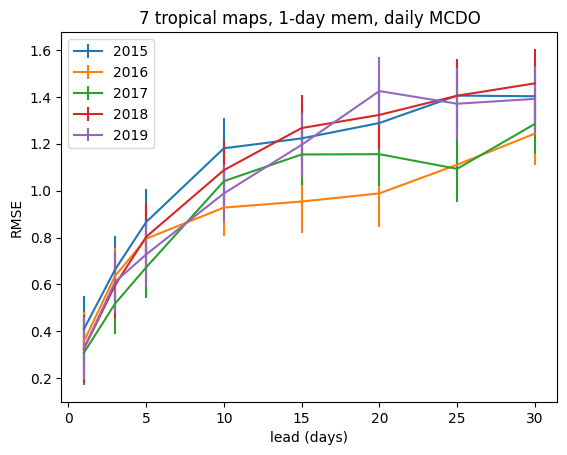

In [5]:
import matplotlib.pyplot as plt 

plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,0], yerr=err[:,0], label='2015')
# plt.plot([1,3,5,10,15,20,25,30], RMSE, 'o-', label=['2015','2016','2017','2018','2019'])
plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,1], yerr=err[:,1], label='2016')
plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,2], yerr=err[:,2], label='2017')
plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,3], yerr=err[:,3], label='2018')
plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,4], yerr=err[:,4], label='2019')
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title('7 tropical maps, 1-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

Text(0, 0.5, 'BCC')

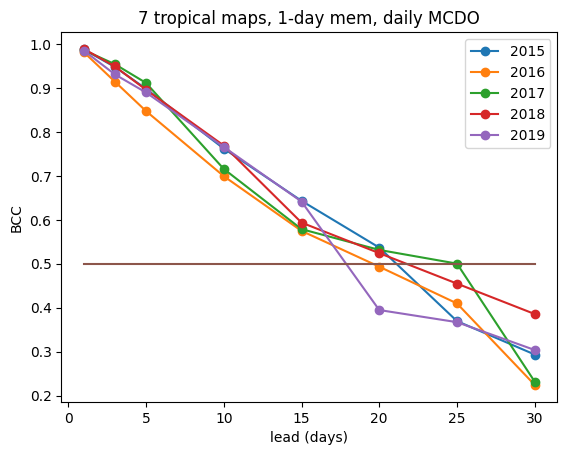

In [6]:
import matplotlib.pyplot as plt 

# plt.errorbar([1,3,5,10,15,20,25,30], BCC[:,3], yerr=err[:,3])
plt.plot([1,3,5,10,15,20,25,30], BCC, 'o-', label=['2015','2016','2017','2018','2019'])
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,1], yerr=err[:,1], label='2016')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,2], yerr=err[:,2], label='2017')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,3], yerr=err[:,3], label='2018')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,4], yerr=err[:,4], label='2019')
plt.plot([1,3,5,10,15,20,25,30], 0.5 * np.ones(8))
plt.legend()
plt.title('7 tropical maps, 1-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')

In [20]:
iniRMM = xr.open_dataset('/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc')
a = iniRMM.sel(time=slice('2015-01-01','2016-12-30'))
b = iniRMM.sel(time=slice('2017-01-01','2019-12-31'))

iniRMM = xr.concat((a,b), dim='time')
RMM1 = iniRMM['RMM'][:,0]
RMM2 = iniRMM['RMM'][:,1]
IniAmp = np.sqrt(RMM1 * RMM1 + RMM2 * RMM2)

dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/7maps_MCDO_36yrtraining_RMMERA5_filtered_trop/output/'

BCC = np.zeros(8)
RMSE = np.zeros(8)
err = np.zeros(8)

for i, lead in zip(np.arange(8),[1,3,5,10,15,20,25,30]):
    dsp0 = []
    dst0 = []
    dspstd0 = []
    for yn in np.arange(2015,2020):
        fnp = dirn + 'predicted_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnt = dirn + 'truth_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'
        fnpstd = dirn + 'predicted_disstd_MCDO_UNET_7mapstrop_RMMERA5_36yr_lead' + str(lead) + '_dailyinput_mem1d' + str(yn) + '.csv'

        dsp = pd.read_csv(fnp, header=None, names=['RMMp1','RMMp2'])
        dsp0.append(dsp)
        dst = pd.read_csv(fnt, header=None, names=['RMMt1','RMMt2'])
        dst0.append(dst)
        dspstd = pd.read_csv(fnpstd, header=None, names=['std1','std2'])
        dspstd0.append(dspstd)

    dsp = pd.concat(dsp0, axis=0, ignore_index=True)
    dst = pd.concat(dst0, axis=0, ignore_index=True)
    dspstd = pd.concat(dspstd0, axis=0, ignore_index=True)


    ds = pd.concat((dsp,dst,dspstd), axis=1)
    ds['IniAmp'] = IniAmp.values 

    ds = ds.loc[ds['IniAmp']>=1]

    r1p = np.asarray(ds['RMMp1'])
    r2p = np.asarray(ds['RMMp2'])
    r1t = np.asarray(ds['RMMt1'])
    r2t = np.asarray(ds['RMMt2'])
    std1 = np.asarray(ds['std1'])
    std2 = np.asarray(ds['std2'])

    del ds 
    del dsp 
    del dst 

    A = np.sum(r1p * r1t + r2p * r2t)
    B = np.sqrt(np.sum(r1p * r1p + r2p * r2p))
    C = np.sqrt(np.sum(r1t * r1t + r2t * r2t))
    BCC[i] = A / B / C 
    d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
    RMSE[i] = np.sqrt(np.mean(d))
    err[i] = np.mean(np.sqrt(std1*std1+std2*std2)/2.0)



Text(0, 0.5, 'RMSE')

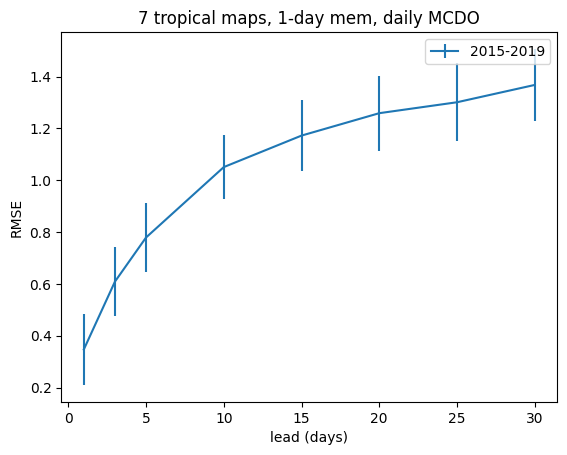

In [23]:
import matplotlib.pyplot as plt 

plt.errorbar([1,3,5,10,15,20,25,30], RMSE, yerr=err, label='2015-2019')
# plt.plot([1,3,5,10,15,20,25,30], 1.2 * np.ones(8))
plt.legend()
plt.title('7 tropical maps, 1-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')

Text(0, 0.5, 'BCC')

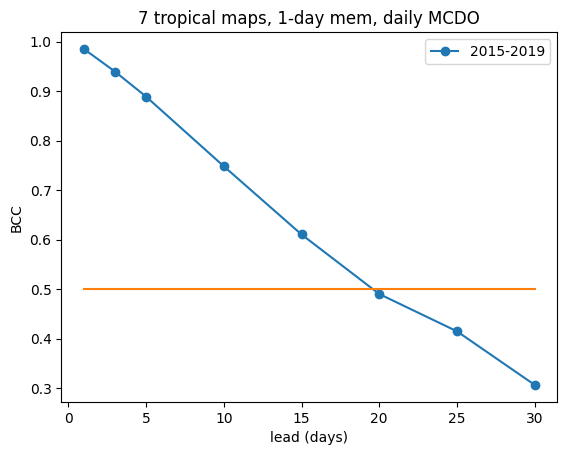

In [22]:
import matplotlib.pyplot as plt 

# plt.errorbar([1,3,5,10,15,20,25,30], BCC[:,3], yerr=err[:,3])
plt.plot([1,3,5,10,15,20,25,30], BCC, 'o-', label='2015-2019')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,1], yerr=err[:,1], label='2016')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,2], yerr=err[:,2], label='2017')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,3], yerr=err[:,3], label='2018')
# plt.errorbar([1,3,5,10,15,20,25,30], RMSE[:,4], yerr=err[:,4], label='2019')
plt.plot([1,3,5,10,15,20,25,30], 0.5 * np.ones(8))
plt.legend()
plt.title('7 tropical maps, 1-day mem, daily MCDO')
plt.xlabel('lead (days)')
plt.ylabel('BCC')